# Fspeptide Analysis

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import msmbuilder.utils as msmUtils
from msmbuilder.tpt import mfpts
import mdtraj as md
from scipy import ndimage
from scipy import stats
%matplotlib inline

C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
# Base folder with all the data
base = 'C:\\Users\\Christian\\Documents\\GitHub\\Protein_Dynamics_TJ\\MSM_Builder_Test\\PC_Data\\'
data_folder = base + 'fspeptide\\sim_datasets\\'
rd_folder = base + 'fspeptide\\reduced_dimension\\'
pc_folder = base + 'fspeptide\\principal_components\\'
video_folder = base + 'fspeptide\\videos\\'

In [187]:
num_frames = 10000
n_neighbors = 100 #100 best for SE for 5000 frames

In [139]:
# Import the coordinates of each frame in the tICA space, saved from the MSMBuilder.
tICA_coordinates = np.loadtxt(data_folder + 'tICA_coord_+fspeptide.csv', delimiter=',')

# Import raw dihedral features and corresponding indices
X_dihedral = np.loadtxt(data_folder + 'raw_angle_' + str(num_frames) + '.csv', delimiter=',')
indices = np.loadtxt(data_folder + 'indices_' + str(num_frames) + '.csv', delimiter=',').astype(int)

#### Compute PCA

In [164]:
pca = PCA(n_components=2)
X_pc = pca.fit_transform(X_dihedral)
X_iso = np.loadtxt(rd_folder + 'X_isomap_40_40_' + str(num_frames) + '.csv', delimiter=',')
X_iso = pca.fit_transform(X_iso)

#### Compute Spectral Embedding

In [188]:
se = manifold.SpectralEmbedding(n_neighbors=n_neighbors, n_components=3)
X_se = pca.fit_transform(se.fit_transform(X_dihedral))
#X_se = se.fit_transform(X_dihedral)

#### tICA Distance Analysis

In [11]:
# Function for plotting various distance vs tICA
def plot_against_tICA(tx, x, indices, num_points=100):
    xdist = []
    txdist = []
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        xdist.append(np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :]))
        txdist.append(np.linalg.norm(tx[indices[frame_pair[0]],:] - tx[indices[frame_pair[1]], :]))
    plt.scatter(xdist, txdist)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(xdist),(np.array(txdist)))
    return r_value**2

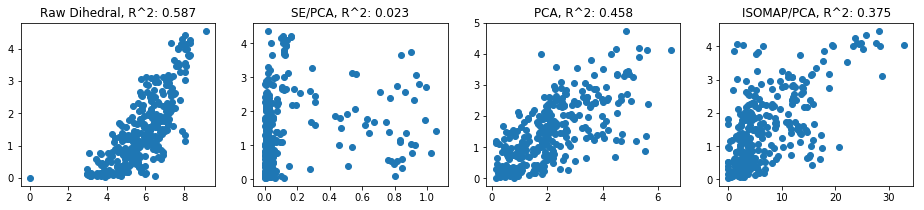

In [133]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
r_2 = plot_against_tICA(tICA_coordinates[:, 0:2], X_dihedral, indices, 300);plt.title('Raw Dihedral, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 2)
r_2 = plot_against_tICA(tICA_coordinates[:, 0:2], X_se, indices, 300);plt.title('SE/PCA, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 3)
r_2 = plot_against_tICA(tICA_coordinates[:, 0:2], X_pc, indices, 300);plt.title('PCA, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 4)
r_2 = plot_against_tICA(tICA_coordinates[:, 0:2], X_iso, indices, 300);plt.title('ISOMAP/PCA, R^2: ' + str(np.round(r_2,3)))

#### MFPT Distance Analysis

In [20]:
# Import MSM files
msm = msmUtils.load(data_folder + 'msm_fspeptide.pkl')
sample_cluster_assignments = np.loadtxt(data_folder + 'sample_cluster_assignment_' + str(num_frames) + '.csv', delimiter=',')

In [22]:
# Function for plotting various distance vs MFPT
def plot_against_MFPT(msm, x, sample_cluster_assignments, num_points=100):
    xdist = []
    mfpt = []
    mfpt_matrix = (mfpts(msm) + mfpts(msm).transpose())/2
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        if sample_cluster_assignments[frame_pair[0]] not in msm.mapping_.keys():
            continue
        if sample_cluster_assignments[frame_pair[1]] not in msm.mapping_.keys():
            continue
        msm_frame_pair = (msm.mapping_[sample_cluster_assignments[frame_pair[0]]], msm.mapping_[sample_cluster_assignments[frame_pair[1]]])
        d = np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :], 2)
        m = mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]]
        if msm_frame_pair[0] != msm_frame_pair[1]:
            xdist.append(d)
            mfpt.append(np.sqrt(m))
    plt.scatter(xdist, mfpt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(xdist),(np.array(mfpt)))
    return r_value**2

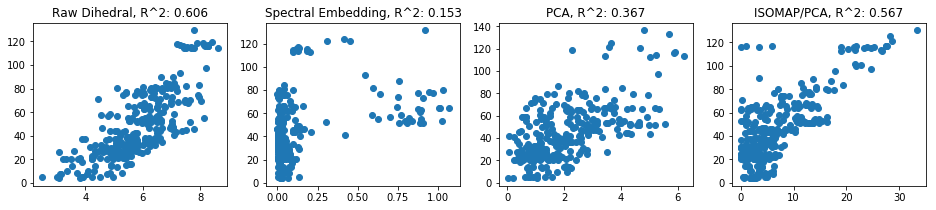

In [132]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
num_points = 300
r_2 = plot_against_MFPT(msm, X_dihedral, sample_cluster_assignments, num_points);plt.title('Raw Dihedral, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 2)
r_2 = plot_against_MFPT(msm, X_se, sample_cluster_assignments, num_points);plt.title('Spectral Embedding, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 3)
r_2 = plot_against_MFPT(msm, X_pc, sample_cluster_assignments, num_points);plt.title('PCA, R^2: ' + str(np.round(r_2,3)))
plt.subplot(1, 4, 4)
r_2 = plot_against_MFPT(msm, X_iso, sample_cluster_assignments, num_points);plt.title('ISOMAP/PCA, R^2: ' + str(np.round(r_2,3)))

#### tIC vs Dynamical Directions found by SpectralEmbedding/PCA

The directions found by SpectralEmbedding and PCA are compared against tICs.

In [25]:
# Function for plotting various distance vs MFPT
def plot_against_tICA_comp(tx, x, tx_comp, x_comp, indices, num_indices):
    plt.scatter(x[:num_indices, x_comp], tx[indices[:num_indices], tx_comp])

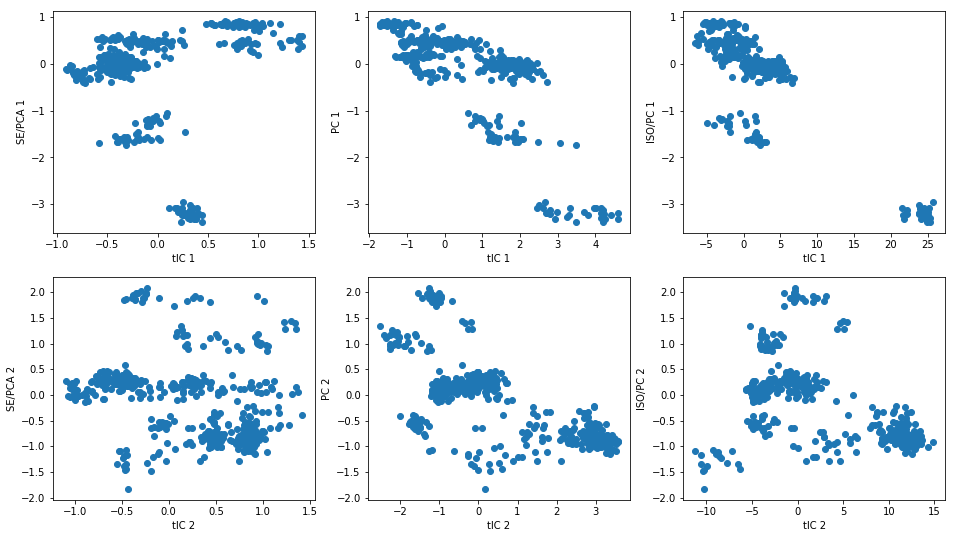

In [30]:
plt.figure(figsize=(4*4, 3*3))
num_points = 500
plt.subplot(2, 3, 1)
plot_against_tICA_comp(tICA_coordinates, X_se, 0, 0, indices, num_points); plt.ylabel('SE/PCA 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 3)
plot_against_tICA_comp(tICA_coordinates, X_iso, 0, 0, indices, num_points); plt.ylabel('ISO/PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 2)
plot_against_tICA_comp(tICA_coordinates, X_pc, 0, 0, indices, num_points); plt.ylabel('PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 4)
plot_against_tICA_comp(tICA_coordinates, X_se, 1, 1, indices, num_points); plt.ylabel('SE/PCA 2'); plt.xlabel('tIC 2')
plt.subplot(2, 3, 6)
plot_against_tICA_comp(tICA_coordinates, X_iso, 1, 1, indices, num_points); plt.ylabel('ISO/PC 2'); plt.xlabel('tIC 2')
plt.subplot(2, 3, 5)
plot_against_tICA_comp(tICA_coordinates, X_pc, 1, 1, indices, num_points); plt.ylabel('PC 2'); plt.xlabel('tIC 2')

#### Energy landscapes

Dynamical directions found by tICA, Spectral Embedding and PCA

In [31]:
def plot_heatmap(X_se):
    x = X_se[:,0]
    y = X_se[:,1]
    xedges, yedges = np.linspace(min(x), max(x), 30), np.linspace(min(y), max(y), 30)
    hist, xedges, yedges = np.histogram2d(X_se[:,0],X_se[:,1],(xedges, yedges))
    #hist = np.log(hist)
    xidx = np.clip(np.digitize(X_se[:,0], xedges), 0, hist.shape[0]-1)
    yidx = np.clip(np.digitize(X_se[:,1], yedges), 0, hist.shape[1]-1)
    c = -np.log(hist[xidx, yidx])
    plt.scatter(X_se[:,0], X_se[:,1], c=c, edgecolor='none', cmap=plt.cm.Spectral)
    cb = plt.colorbar()
    cb.set_label('log10(N)')

C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


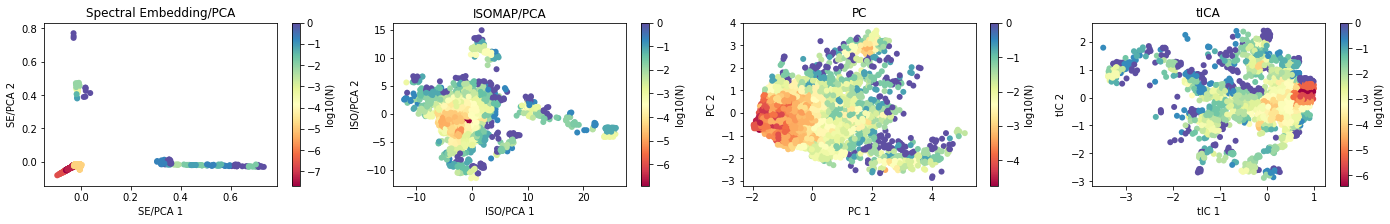

In [190]:
plt.figure(figsize=(6*4, 3))
plt.subplot(1, 4, 1)
plot_heatmap(X_se); plt.xlabel('SE/PCA 1'); plt.ylabel('SE/PCA 2'); plt.title('Spectral Embedding/PCA')
plt.subplot(1, 4, 2)
plot_heatmap(X_iso); plt.xlabel('ISO/PCA 1'); plt.ylabel('ISO/PCA 2'); plt.title('ISOMAP/PCA')
plt.subplot(1, 4, 3)
plot_heatmap(X_pc); plt.xlabel('PC 1'); plt.ylabel('PC 2'); plt.title('PC')
plt.subplot(1, 4, 4)
plot_heatmap(tICA_coordinates[indices,:]); plt.xlabel('tIC 1'); plt.ylabel('tIC 2'); plt.title('tICA')

#### Video of 1st Reaction Coordinate

In [15]:
X_XYZ = np.loadtxt(data_folder + 'raw_XYZ_28000.csv', delimiter=',')
X_XYZ = X_XYZ[indices,:]

In [16]:
def save_traj(traj, filename):
    seq = np.reshape(traj, (traj.shape[0], int(traj.shape[1]/3), 3))
    md_traj = md.Trajectory(seq, md.load(base + 'fspeptide\\fs-peptide.pdb').topology)
    md_traj.save_xtc(video_folder + filename)

In [189]:
# Sampled along first dimension
video_length = 3000
sample_rate = int(num_frames/video_length)+1

direction = tICA_coordinates[indices,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'first_tICA_sample.xtc')

direction = X_se[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'first_SE_' + str(n_neighbors) + '_sample.xtc')

direction = X_pc[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'first_PC_sample.xtc')

direction = X_iso[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'first_ISO_sample.xtc')

C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [112]:
# Sampled along second dimension
direction = tICA_coordinates[indices,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'second_tICA_sample.xtc')

direction = X_se[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'second_SE_dim_sample.xtc')

direction = X_pc[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'second_PC_sample.xtc')

direction = X_iso[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj[::sample_rate], 'second_ISO_sample.xtc')

C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


#### FsPeptide Specific Analysis - Folding Transition (First dominant dynamic process)

We measured the Ala1-Ala20 distance against the first dynamical mode found by PCA/SE/tICA.

In [52]:
# 264 atoms in th fspeptide
# atom 9 is the alpha carbon of alanine 1
# atom 251 is the alpha carbon of alanine 21
phe92_atom = 9
phe141_atom = 251
phe92_idx = range(3*(phe92_atom-1), 3*(phe92_atom-1)+3)
phe141_idx = range(3*(phe141_atom-1), 3*(phe141_atom-1)+3)
phe92_coor = X_XYZ[:, phe92_idx]
phe141_coor = X_XYZ[:, phe141_idx]
print(X_XYZ.shape)
dist_92_141 = np.sqrt(np.sum(((phe92_coor-phe141_coor)**2), axis=1))

(4952, 792)


In [53]:
def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='valid')
    y_smooth = ndimage.filters.gaussian_filter1d(y, box_pts)
    return y_smooth

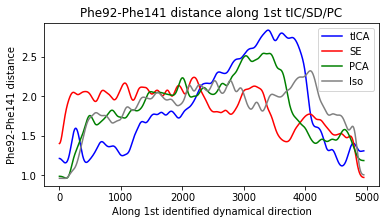

In [56]:
# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(dist_92_141[idx_tica], 50), 'b', label='tICA'); 
plt.title('Phe92-Phe141 distance along 1st tIC/SD/PC')
plt.ylabel('Phe92-Phe141 distance'); plt.xlabel('Along 1st identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):]#[::-1]
plt.plot(smooth(dist_92_141[idx_se], 50), 'r', label='SE'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(dist_92_141[idx_pc], 50), 'g', label='PCA');
idx_iso = X_iso[:,1].argsort()[-len(X_iso[:,1]):][::-1]
plt.plot(smooth(dist_92_141[idx_iso], 50), 'gray', label='Iso');
plt.legend()

Measure % alpha helix to measure how folded FsPeptide is

In [67]:
X_pp = np.loadtxt(data_folder + 'raw_phi_psi.csv', delimiter=',')
X_pp = np.rad2deg(X_pp)
X_pp = X_pp[indices,:]

In [101]:
# Average phi, psi angles for alpha helix (-64 +/- 7, -41 +/- 7) 
phi_avg = -64
psi_avg = -41
d_phi = 7
d_psi = 7
num_angle = int(X_pp.shape[1]/2)

# Calculate percent helix
X_percent = []
for frame in X_pp:
    count = 0
    phi = frame[0:num_angle]
    psi = frame[num_angle:]
    for idx in range(num_angle):
        if abs(phi[idx] - phi_avg) <= d_phi and abs(psi[idx] - psi_avg) <= d_psi:
            count += 1
    X_percent.append(count/num_angle)
X_percent = np.array(X_percent)#/np.max(X_percent)

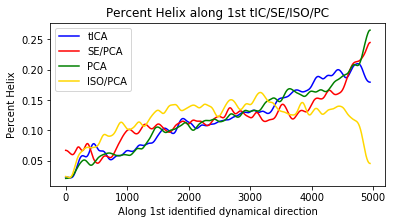

In [191]:

# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,0].argsort()[-len(tICA_coordinates[indices,0]):]
plt.plot(smooth(X_percent[idx_tica], 50), 'b', label='tICA'); 
plt.title('Percent Helix along 1st tIC/SE/ISO/PC')
plt.ylabel('Percent Helix'); plt.xlabel('Along 1st identified dynamical direction')
idx_se = X_se[:,0].argsort()[-len(X_se[:,0]):][::-1]
plt.plot(smooth(X_percent[idx_se], 50), 'r', label='SE/PCA'); 
idx_pc = X_pc[:,0].argsort()[-len(X_pc[:,0]):][::-1]
plt.plot(smooth(X_percent[idx_pc], 50), 'g', label='PCA');
idx_iso = X_iso[:,0].argsort()[-len(X_iso[:,0]):][::-1]
plt.plot(smooth(X_percent[idx_iso], 50), 'gold', label='ISO/PCA');
plt.legend()

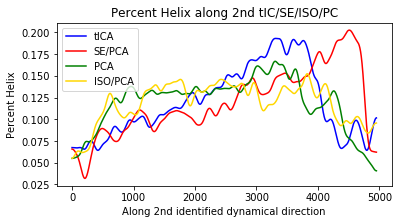

In [142]:

# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(X_percent[idx_tica], 50), 'b', label='tICA'); 
plt.title('Percent Helix along 2nd tIC/SE/ISO/PC')
plt.ylabel('Percent Helix'); plt.xlabel('Along 2nd identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):][::-1]
plt.plot(smooth(X_percent[idx_se], 50), 'r', label='SE/PCA'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(X_percent[idx_pc], 50), 'g', label='PCA');
idx_iso = X_iso[:,1].argsort()[-len(X_iso[:,1]):][::-1]
plt.plot(smooth(X_percent[idx_iso], 50), 'gold', label='ISO/PCA');
plt.legend()